In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
 
from sklearn.model_selection import train_test_split
from sklearn import metrics
 
import cv2
import gc
import os
 
import tensorflow as tf
from tensorflow import keras
from keras import layers
 
import warnings
warnings.filterwarnings('ignore')

E:\Users\User\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
from zipfile import ZipFile
 
data_path = "C:/Users/User/Downloads/Lung_Colon/archive.zip"
 
with ZipFile(data_path,'r') as zip:
  zip.extractall()
  print('The data set has been extracted.')

In [2]:
path = 'lung_colon_image_set/lung_image_sets'
classes = os.listdir(path)
classes

['lung_aca', 'lung_n', 'lung_scc']

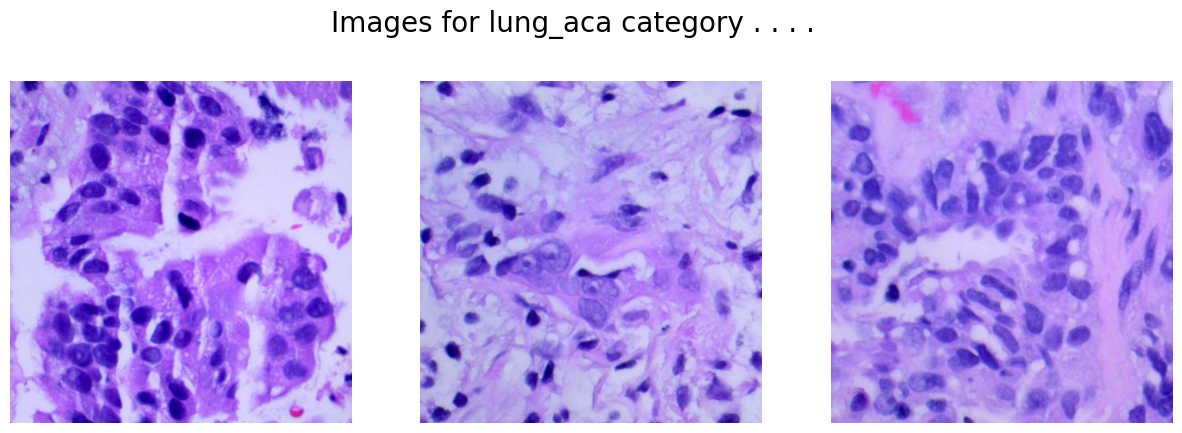

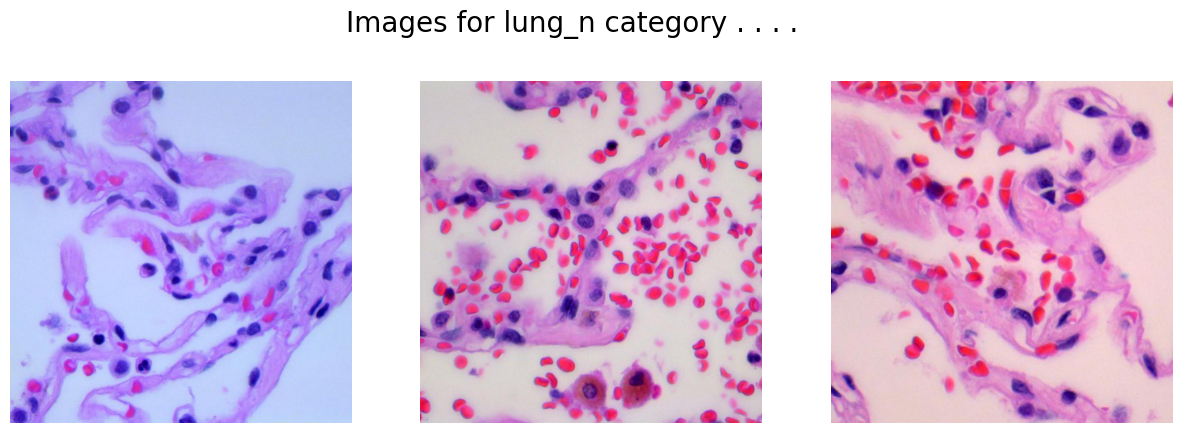

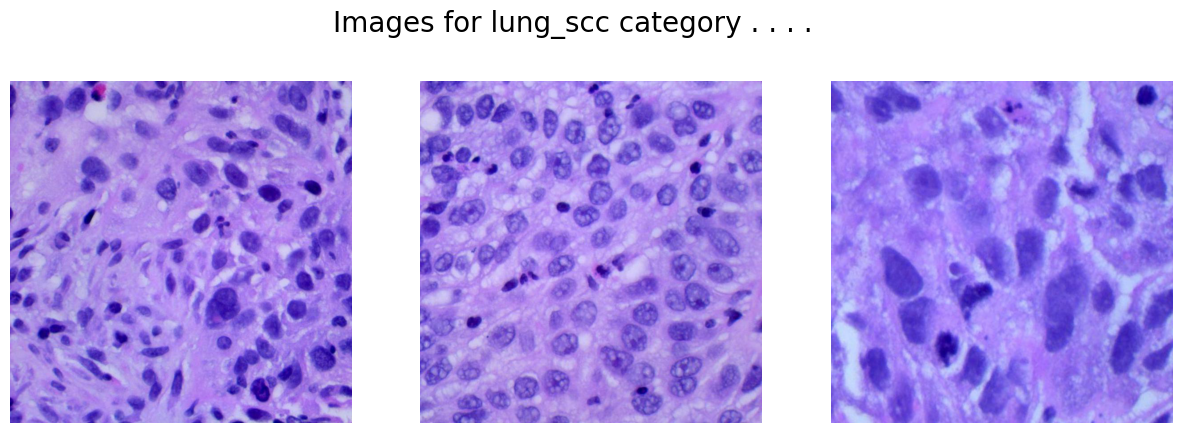

In [3]:
path = 'lung_colon_image_set/lung_image_sets'
 
for cat in classes:
    image_dir = f'{path}/{cat}'
    images = os.listdir(image_dir)
 
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'Images for {cat} category . . . .', fontsize=20)
 
    for i in range(3):
        k = np.random.randint(0, len(images))
        img = np.array(Image.open(f'{path}/{cat}/{images[k]}'))
        ax[i].imshow(img)
        ax[i].axis('off')
    plt.show()

In [4]:
IMG_SIZE = 256
SPLIT = 0.2
EPOCHS = 10
BATCH_SIZE = 64


In [5]:

X = []
Y = []
 
for i, cat in enumerate(classes):
  images = glob(f'{path}/{cat}/*.jpeg')
 
  for image in images:
    img = cv2.imread(image)
     
    X.append(cv2.resize(img, (IMG_SIZE, IMG_SIZE)))
    Y.append(i)
 
X = np.asarray(X)
one_hot_encoded_Y = pd.get_dummies(Y).values

In [6]:

X_train, X_val, Y_train, Y_val = train_test_split(X, one_hot_encoded_Y,
                                                  test_size = SPLIT,
                                                  random_state = 2022)
print(X_train.shape, X_val.shape)

(12000, 256, 256, 3) (3000, 256, 256, 3)


In [7]:
model = keras.models.Sequential([
    layers.Conv2D(filters=32,
                  kernel_size=(5, 5),
                  activation='relu',
                  input_shape=(IMG_SIZE,
                               IMG_SIZE,
                               3),
                  padding='same'),
    layers.MaxPooling2D(2, 2),
 
    layers.Conv2D(filters=64,
                  kernel_size=(3, 3),
                  activation='relu',
                  padding='same'),
    layers.MaxPooling2D(2, 2),
 
    layers.Conv2D(filters=128,
                  kernel_size=(3, 3),
                  activation='relu',
                  padding='same'),
    layers.MaxPooling2D(2, 2),
 
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(3, activation='softmax')
])

In [8]:

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 64, 64, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 32, 32, 128)       0

In [ ]:

keras.utils.plot_model(
    model,
    show_shapes = True,
    show_dtype = True,
    show_layer_activations = True
)

In [9]:

model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [10]:

from keras.callbacks import EarlyStopping, ReduceLROnPlateau
 
 
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_accuracy') > 0.90:
            print('\n Validation accuracy has reached upto \
                      90% so, stopping further training.')
            self.model.stop_training = True
 
 
es = EarlyStopping(patience=3,
                   monitor='val_accuracy',
                   restore_best_weights=True)
 
lr = ReduceLROnPlateau(monitor='val_loss',
                       patience=2,
                       factor=0.5,
                       verbose=1)

In [11]:

history = model.fit(X_train, Y_train,
                    validation_data = (X_val, Y_val),
                    batch_size = BATCH_SIZE,
                    epochs = EPOCHS,
                    verbose = 1,
                    callbacks = [es, lr, myCallback()])

Epoch 1/10


188/188 [==============================] - 216s 1s/step - loss: 0.3604 - accuracy: 0.8549 - val_loss: 0.4335 - val_accuracy: 0.8200 - lr: 0.0010
Epoch 2/10
188/188 [==============================] - 215s 1s/step - loss: 0.2073 - accuracy: 0.9187 - val_loss: 3.1074 - val_accuracy: 0.3823 - lr: 0.0010
Epoch 3/10
188/188 [==============================] - ETA: 0s - loss: 0.1672 - accuracy: 0.9344
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
188/188 [==============================] - 220s 1s/step - loss: 0.1672 - accuracy: 0.9344 - val_loss: 8.1927 - val_accuracy: 0.5600 - lr: 0.0010
Epoch 4/10
188/188 [==============================] - 215s 1s/step - loss: 0.1038 - accuracy: 0.9633 - val_loss: 2.0624 - val_accuracy: 0.6750 - lr: 5.0000e-04


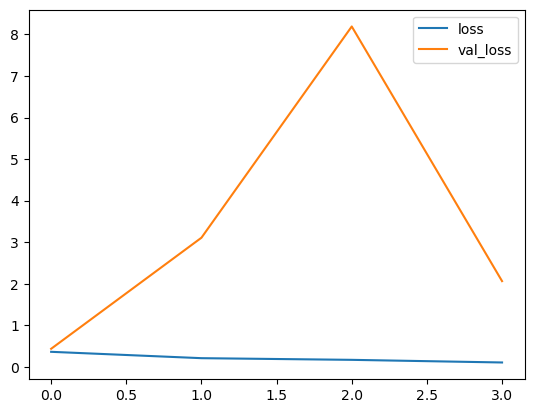

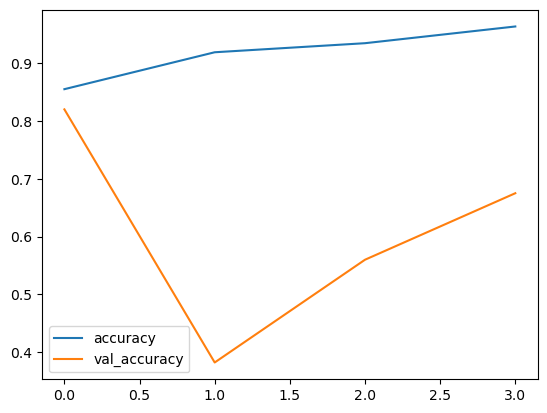

In [12]:

history_df = pd.DataFrame(history.history)
history_df.loc[:,['loss','val_loss']].plot()
history_df.loc[:,['accuracy','val_accuracy']].plot()
plt.show()

In [13]:
Y_pred = model.predict(X_val)
Y_val = np.argmax(Y_val, axis=1)
Y_pred = np.argmax(Y_pred, axis=1)

94/94 [==============================] - 10s 105ms/step


In [14]:
metrics.confusion_matrix(Y_val, Y_pred)

array([[957,   6,  24],
       [ 47, 929,   1],
       [462,   0, 574]], dtype=int64)

In [15]:

print(metrics.classification_report(Y_val, Y_pred,
                                    target_names=classes))

              precision    recall  f1-score   support

    lung_aca       0.65      0.97      0.78       987
      lung_n       0.99      0.95      0.97       977
    lung_scc       0.96      0.55      0.70      1036

    accuracy                           0.82      3000
   macro avg       0.87      0.82      0.82      3000
weighted avg       0.87      0.82      0.82      3000



In [16]:
model.save('lung_cancer_detection_model.h5')

In [37]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the saved model
model = tf.keras.models.load_model('lung_cancer_detection_model.h5')

# Load and preprocess the image to make it compatible with the model
img_path = 'lung_colon_image_set/lung_image_sets/lung_n/lungn40.jpeg'  # Replace with the actual path to your image
img = image.load_img(img_path, target_size=(256, 256))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Normalize the image

# Make a prediction
prediction = model.predict(img_array)

print(prediction)

# Interpret the prediction
if prediction[0][0] > 9e-29:
    print("The Patient has a healthy Lung")
else:
    print("The Patient is suffering from either Squamous Cell or Adenocarcinoma")


1/1 [==============================] - 0s 104ms/step
[[9.4270244e-29 8.7988349e-12 1.0000000e+00]]
The Patient has a healthy Lung


In [ ]:
    +-

In [ ]:
    +-

In [ ]:
    +-

In [ ]:
    +-

In [ ]:
    +-

In [ ]:
    +-

In [ ]:
    +-

In [ ]:
    +-

In [ ]:
    +-

In [ ]:
    +-

In [ ]:
    +-

In [ ]:
    +-

In [ ]:
    +-

In [ ]:
    +-

In [ ]:
    +-

In [ ]:
    +-

In [ ]:
    +-

In [ ]:
    +-

In [ ]:
    +-

In [ ]:
    +-

In [ ]:
    +-

In [ ]:
    +-